In [ ]:
# Paste this entire cell into Google Colab. It will:
# - let you upload a CSV,
# - attempt to detect encoding and datetime,
# - test stationarity (ADF) and difference if needed,
# - run pairwise Granger causality tests,
# - save results to "/content/granger_results.csv" in Colab.

# Required packages: pandas, numpy, statsmodels
# In Colab you can install missing packages via: !pip install statsmodels

import pandas as pd
import numpy as np
import os
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
import warnings
warnings.filterwarnings("ignore")

# ---- upload file in Colab ----
from google.colab import files
print("Select the CSV file to upload (choose your climatedata.csv):")
uploaded = files.upload()  # interactive upload
if not uploaded:
    raise RuntimeError("No file uploaded.")
# take the first uploaded filename
fname = list(uploaded.keys())[0]
print("Uploaded:", fname)

# ---- read with encoding fallback ----
encodings_to_try = ['utf-8', 'latin1', 'cp1252', 'utf-16']
for enc in encodings_to_try:
    try:
        df = pd.read_csv(fname, encoding=enc)
        print(f"Successfully read CSV with encoding: {enc}")
        break
    except Exception as e:
        print(f"Failed with {enc}: {e}")
else:
    raise UnicodeDecodeError("Unable to decode file with tried encodings. If you know the encoding, re-upload specifying it.")

print("Shape:", df.shape)
print("Columns:", df.columns.tolist())

# ---- try to detect datetime index ----
datetime_col = None
candidates = [c for c in df.columns if 'date' in c.lower() or 'time' in c.lower()]
if candidates:
    for c in candidates:
        parsed = pd.to_datetime(df[c], errors='coerce')
        if parsed.notna().sum() > len(df) * 0.5:
            datetime_col = c
            df[c] = parsed
            break

# fallback: try first column
if datetime_col is None:
    first_col = df.columns[0]
    parsed = pd.to_datetime(df[first_col], errors='coerce')
    if parsed.notna().sum() > len(df) * 0.5:
        datetime_col = first_col
        df[first_col] = parsed

if datetime_col:
    print(f"Detected datetime column: {datetime_col} -> setting as index.")
    df = df.set_index(datetime_col).sort_index()
else:
    print("No datetime column detected automatically; the data will be used as-is (integer index).")

# ---- pick numeric cols ----
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print("Numeric columns:", numeric_cols)
if len(numeric_cols) < 2:
    raise ValueError("Need at least two numeric columns for Granger tests.")

# ---- ADF test helper (and automatic differencing up to 2 diffs) ----
def adf_test(series, signif=0.05, maxdiff=2):
    s = series.dropna().astype(float)
    if len(s) < 10:
        return {"pvalue": np.nan, "stationary": False, "ndiffs": None, "reason": "too short"}
    nd = 0
    while nd <= maxdiff:
        try:
            res = adfuller(s, autolag='AIC')
            p = res[1]
            if p < signif:
                return {"pvalue": p, "stationary": True, "ndiffs": nd, "adf_stat": res[0]}
            else:
                s = s.diff().dropna()
                nd += 1
        except Exception as e:
            return {"pvalue": np.nan, "stationary": False, "ndiffs": None, "reason": str(e)}
    return {"pvalue": p, "stationary": False, "ndiffs": nd, "adf_stat": res[0] if 'res' in locals() else None}

df_work = df.copy()
stationarity_report = {}
for c in numeric_cols:
    rep = adf_test(df_work[c], signif=0.05, maxdiff=2)
    stationarity_report[c] = rep
    if rep.get("ndiffs") and rep["ndiffs"] > 0:
        df_work[c] = df_work[c].diff(rep["ndiffs"])

# align and drop NA
df_work = df_work[numeric_cols].dropna()
n_obs = len(df_work)
max_lag = min(12, max(1, int(np.floor(n_obs / 5))))
print(f"Observations used: {n_obs}, chosen max_lag: {max_lag}")

# ---- pairwise Granger causality tests ----
results = []
for cause in numeric_cols:
    for effect in numeric_cols:
        if cause == effect:
            continue
        data = df_work[[effect, cause]].dropna()
        if len(data) < (max_lag + 3):
            reduced_maxlag = max(1, int(np.floor(len(data) / 5)))
        else:
            reduced_maxlag = max_lag
        try:
            gc_res = grangercausalitytests(data, maxlag=reduced_maxlag, verbose=False)
            lag_p = {lag: gc_res[lag][0]['ssr_ftest'][1] for lag in gc_res.keys()}
            best_lag = min(lag_p, key=lag_p.get)
            min_p = lag_p[best_lag]
            results.append({
                "cause": cause,
                "effect": effect,
                "min_pvalue": float(min_p),
                "best_lag": int(best_lag),
                "used_maxlag": reduced_maxlag,
                "n_obs": len(data)
            })
        except Exception as e:
            results.append({
                "cause": cause,
                "effect": effect,
                "min_pvalue": np.nan,
                "best_lag": None,
                "used_maxlag": reduced_maxlag,
                "n_obs": len(data),
                "error": str(e)
            })

res_df = pd.DataFrame(results).sort_values("min_pvalue")
outpath = "/content/granger_results.csv"
res_df.to_csv(outpath, index=False)
print("Saved Granger results to:", outpath)

# save a short human summary
summary_path = "/content/granger_summary.txt"
with open(summary_path, "w") as f:
    f.write(f"Total pairs tested: {len(res_df)}\n")
    f.write(f"Pairs with min p < 0.05: {len(res_df[res_df['min_pvalue'] < 0.05])}\n\n")
    f.write("Top 10 pairs by smallest p-value (cause -> effect, p, lag):\n")
    for _, row in res_df.head(10).iterrows():
        f.write(f"{row['cause']} -> {row['effect']}: p={row['min_pvalue']:.4g}, lag={row['best_lag']}\n")
print("Saved summary to:", summary_path)

# show top results
print("\nTop 10 Granger pairs (cause -> effect, min_pvalue, best_lag):")
print(res_df.head(10).to_string(index=False))

Select the CSV file to upload (choose your climatedata.csv):


Saving climatedata.csv to climatedata.csv
Uploaded: climatedata.csv
Failed with utf-8: 'utf-8' codec can't decode byte 0xe6 in position 17: invalid continuation byte
Successfully read CSV with encoding: latin1
Shape: (3971, 10)
Columns: ['system:time_start', 'air_pollution_o3(æmol/m^2)', 'Downward_surface_shortwave_radiationW/m^2', 'Land_surface_temprature_øC', 'air_pollution_no2(æmol/m^2)', 'air_pollution_so2(æmol/m^2)', 'Precipitation_accumulation_mm', 'vapor_pressure_kpa', 'wind_speed_m/s', 'air_pollution_CO(µmol/m^2)']
No datetime column detected automatically; the data will be used as-is (integer index).
Numeric columns: ['Downward_surface_shortwave_radiationW/m^2', 'Land_surface_temprature_øC', 'air_pollution_no2(æmol/m^2)', 'Precipitation_accumulation_mm', 'vapor_pressure_kpa', 'wind_speed_m/s']
Observations used: 439, chosen max_lag: 12
Saved Granger results to: /content/granger_results.csv
Saved summary to: /content/granger_summary.txt

Top 10 Granger pairs (cause -> effect, m

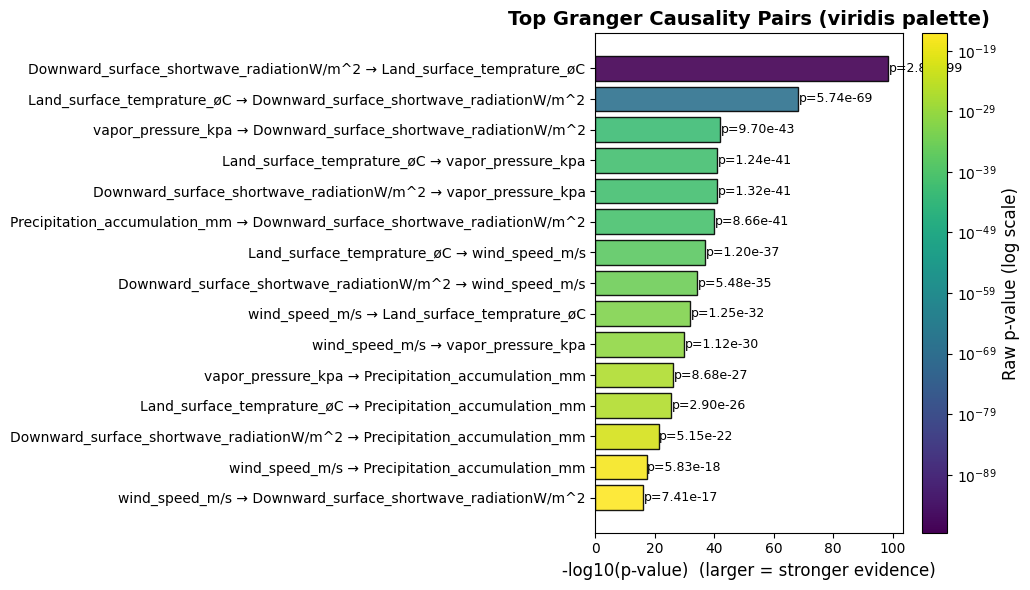

In [ ]:
# 📊 Visualization of top Granger causality pairs with Viridis palette
import matplotlib.pyplot as plt
import matplotlib as mpl

# Select top 15 by smallest p-value
top_pairs = res_df.head(15).copy()
top_pairs = top_pairs[::-1]  # reverse for nicer barh ordering

fig, ax = plt.subplots(figsize=(10, 6))

# Map p-values to viridis colormap
norm = mpl.colors.LogNorm(vmin=top_pairs['min_pvalue'].min(), vmax=top_pairs['min_pvalue'].max())
cmap = mpl.cm.viridis
colors = cmap(norm(top_pairs['min_pvalue']))

bars = ax.barh(
    y=[f"{c} → {e}" for c, e in zip(top_pairs['cause'], top_pairs['effect'])],
    width=-np.log10(top_pairs['min_pvalue']),  # transform for better scale
    color=colors,
    edgecolor="black",
    alpha=0.9
)

# Add colorbar legend
sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label("Raw p-value (log scale)", fontsize=12)

# Titles and labels
ax.set_title("Top Granger Causality Pairs (viridis palette)", fontsize=14, weight="bold")
ax.set_xlabel("-log10(p-value)  (larger = stronger evidence)", fontsize=12)
ax.tick_params(axis="y", labelsize=10)

# Add numeric annotations on bars
for bar, p in zip(bars, top_pairs['min_pvalue']):
    ax.text(
        bar.get_width() + 0.2, bar.get_y() + bar.get_height()/2,
        f"p={p:.2e}", va="center", fontsize=9
    )

plt.tight_layout()
plt.show()